In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

2024-08-02 16:16:49.420116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:16:49.420216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:16:49.535432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Creating directories
dataset_dir = "/kaggle/input/top-agriculture-crop-disease/Crop Diseases"
working_dir = "/kaggle/working/top-agriculture-crop-disease/Crop Diseases"

In [3]:
#creating folder for train,test, val
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'validation')
test_dir = os.path.join(working_dir, 'test')

In [4]:
# Getting the list of folders in the dataset
class_names = [folder for folder in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, folder))]

# Printing the class names
print(class_names)

['Corn___Northern_Leaf_Blight', 'Wheat___Yellow_Rust', 'Sugarcane_Bacterial Blight', 'Potato___Healthy', 'Rice___Neck_Blast', 'Corn___Healthy', 'Wheat___Brown_Rust', 'Corn___Gray_Leaf_Spot', 'Rice___Brown_Spot', 'Sugarcane_Red Rot', 'Sugarcane_Healthy', 'Wheat___Healthy', 'Rice___Leaf_Blast', 'Potato___Late_Blight', 'Rice___Healthy', 'Corn___Common_Rust', 'Potato___Early_Blight']


In [5]:
# Creating directories making sure they exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [6]:
# Splitting data into train, validation, test 
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

In [7]:
# Copying and renaming folders to working directory
for folder_name in class_names:
    old_folder_path = os.path.join(dataset_dir, folder_name)
    new_folder_path = os.path.join(working_dir, folder_name)
    shutil.copytree(old_folder_path, new_folder_path)
    print(f"Copied '{folder_name}' to '{new_folder_path}'")

print("Folder copying completed.")

Copied 'Corn___Northern_Leaf_Blight' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Corn___Northern_Leaf_Blight'
Copied 'Wheat___Yellow_Rust' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Wheat___Yellow_Rust'
Copied 'Sugarcane_Bacterial Blight' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Sugarcane_Bacterial Blight'
Copied 'Potato___Healthy' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Potato___Healthy'
Copied 'Rice___Neck_Blast' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Rice___Neck_Blast'
Copied 'Corn___Healthy' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Corn___Healthy'
Copied 'Wheat___Brown_Rust' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Wheat___Brown_Rust'
Copied 'Corn___Gray_Leaf_Spot' to '/kaggle/working/top-agriculture-crop-disease/Crop Diseases/Corn___Gray_Leaf_Spot'
Copied 'Rice___Brown_Spot' to '/kaggle/working/top-agriculture-crop-disease/Crop Dis

In [8]:
#Splitting data after copying 
for folder_name in class_names:
    class_dir = os.path.join(working_dir, folder_name)
    files = os.listdir(class_dir)
    
    train_files, test_val_files = train_test_split(files, test_size=1 - train_ratio)
    val_files, test_files = train_test_split(test_val_files, test_size=test_ratio / (test_ratio + val_ratio))

    for file in train_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(train_dir, folder_name, file)
        os.makedirs(os.path.join(train_dir, folder_name), exist_ok=True)
        shutil.copy(src, dst)

    for file in val_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(val_dir, folder_name, file)
        os.makedirs(os.path.join(val_dir, folder_name), exist_ok=True)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(class_dir, file)
        dst = os.path.join(test_dir, folder_name, file)
        os.makedirs(os.path.join(test_dir, folder_name), exist_ok=True)
        shutil.copy(src, dst)

print("Data splitting and copying completed.")

Data splitting and copying completed.


In [9]:
train_data = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        train_data.append((file_path, class_name))

In [10]:
train_df = pd.DataFrame(train_data, columns=['File_Path', 'Class_Name'])
train_df

File_Path  \
0     /kaggle/working/top-agriculture-crop-disease/C...   
1     /kaggle/working/top-agriculture-crop-disease/C...   
2     /kaggle/working/top-agriculture-crop-disease/C...   
3     /kaggle/working/top-agriculture-crop-disease/C...   
4     /kaggle/working/top-agriculture-crop-disease/C...   
...                                                 ...   
9311  /kaggle/working/top-agriculture-crop-disease/C...   
9312  /kaggle/working/top-agriculture-crop-disease/C...   
9313  /kaggle/working/top-agriculture-crop-disease/C...   
9314  /kaggle/working/top-agriculture-crop-disease/C...   
9315  /kaggle/working/top-agriculture-crop-disease/C...   

                      Class_Name  
0     Sugarcane_Bacterial Blight  
1     Sugarcane_Bacterial Blight  
2     Sugarcane_Bacterial Blight  
3     Sugarcane_Bacterial Blight  
4     Sugarcane_Bacterial Blight  
...                          ...  
9311           Rice___Brown_Spot  
9312           Rice___Brown_Spot  
9313           Rice___Brown_Spot  
9314           Rice___Brown_Spot  
9315           Rice___Brown_Spot  

[9316 rows x 2 columns]

In [11]:
train_df['Class_Name'].value_counts().sort_index()

Class_Name
Corn___Common_Rust              834
Corn___Gray_Leaf_Spot           359
Corn___Healthy                  813
Corn___Northern_Leaf_Blight     689
Potato___Early_Blight           699
Potato___Healthy                106
Potato___Late_Blight            699
Rice___Brown_Spot               429
Rice___Healthy                 1041
Rice___Leaf_Blast               683
Rice___Neck_Blast               699
Sugarcane_Bacterial Blight       69
Sugarcane_Healthy                69
Sugarcane_Red Rot                69
Wheat___Brown_Rust              631
Wheat___Healthy                 781
Wheat___Yellow_Rust             646
Name: count, dtype: int64

In [12]:
train_df['File_Path'][0]

'/kaggle/working/top-agriculture-crop-disease/Crop Diseases/train/Sugarcane_Bacterial Blight/S_BLB (28).JPG'

In [13]:
#Defining image dimensions for Xception model
img_width, img_height = 299, 299

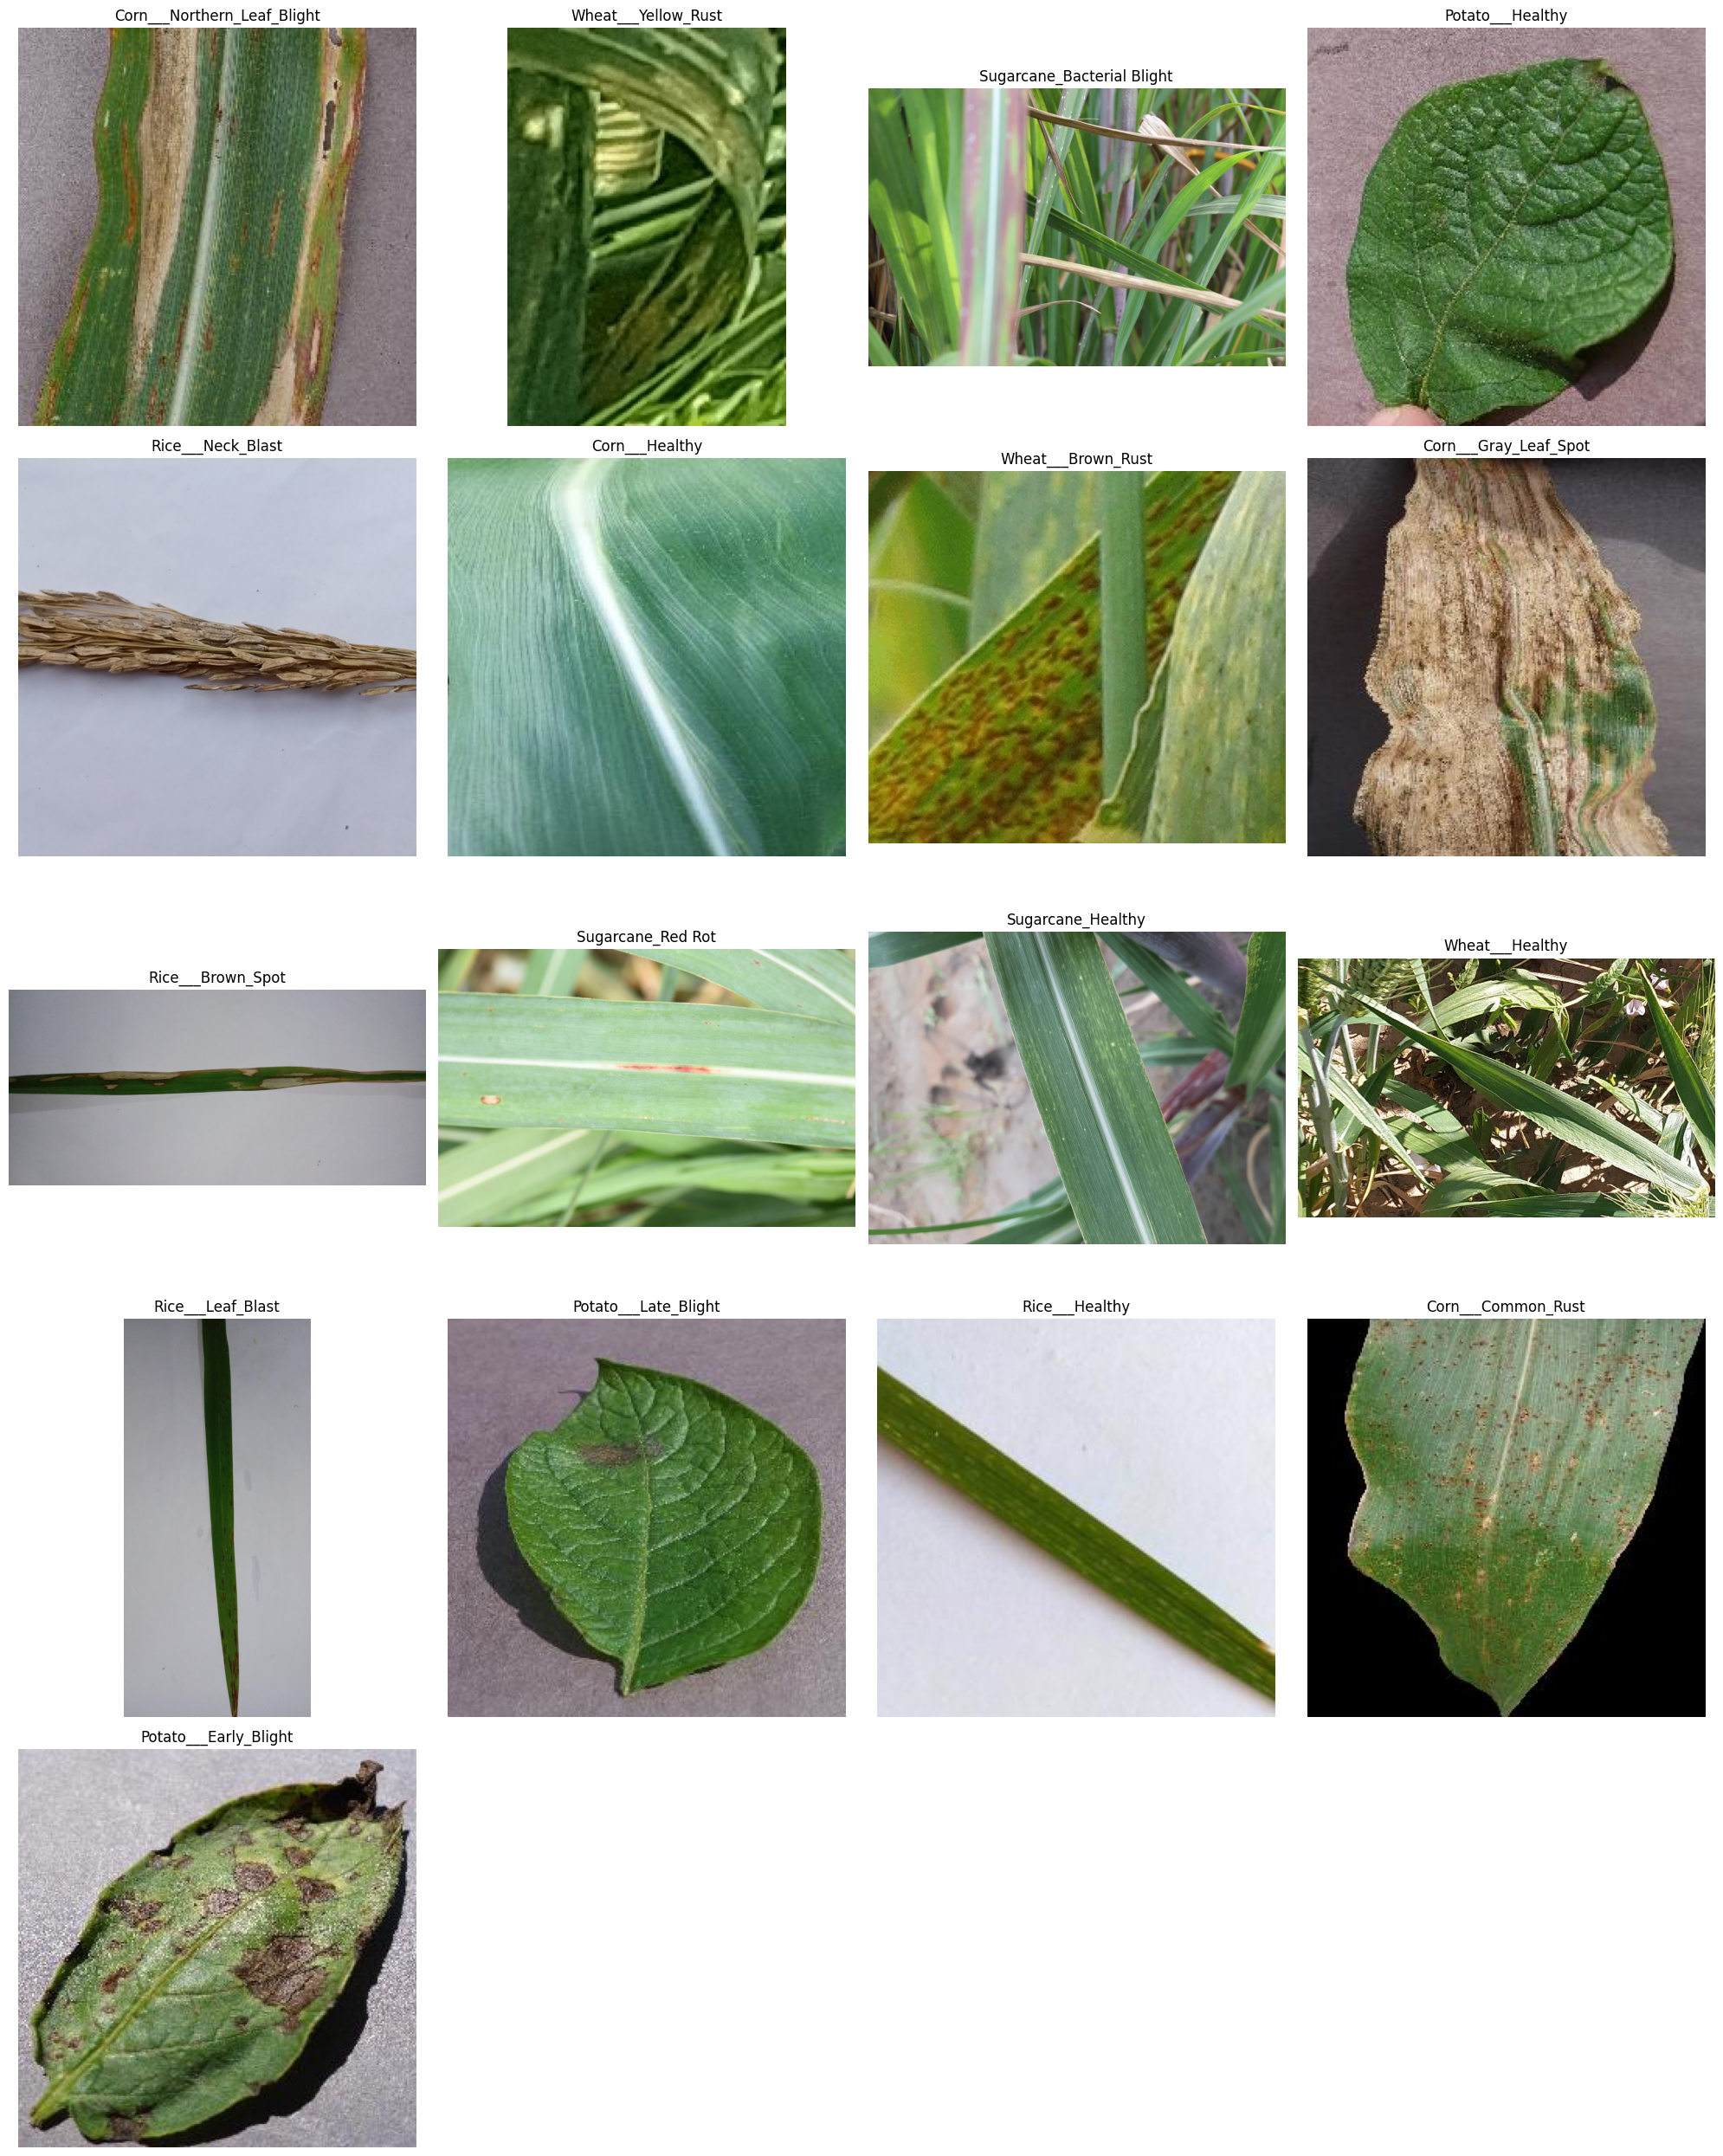

In [14]:
from PIL import Image

# Get the list of class directories
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
images_per_row = 4
num_rows = (len(class_dirs) + images_per_row - 1) // images_per_row
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Display one image from each class
for ax, class_dir in zip(axes, class_dirs):
    # Path to the class directory
    class_path = os.path.join(dataset_dir, class_dir)
    
    
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
   
    if image_files:
        # Load the first image
        image_path = os.path.join(class_path, image_files[0])
        image = Image.open(image_path)
        
        # Display the image
        ax.imshow(image)
        ax.set_title(class_dir)
        ax.axis('off')
    else:
        ax.set_title(f'{class_dir}\nNo images')
        ax.axis('off')


for i in range(len(class_dirs), len(axes)):
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
# Data generators with augmentation for Xception model
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [16]:
# Directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 9316 images belonging to 17 classes.
Found 1330 images belonging to 17 classes.
Found 2678 images belonging to 17 classes.


In [17]:
# Loading the Xception model pre-trained on ImageNet 
base_model = Xception(weights=None, include_top=False)
base_model.load_weights('/kaggle/input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Compiling model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 22,977,081 (87.65 MB)

 Trainable params: 22,922,553 (87.44 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [22]:
len(model.layers)

135

In [23]:
# Training the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-02 16:20:56.345044: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[128,128,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[32,128,147,147]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 16:20:56.371608: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.026692108s
Trying algorithm eng18{k11=2} for conv (f32[

133/292 ━━━━━━━━━━━━━━━━━━━━ 3:06 1s/step - accuracy: 0.6637 - loss: 1.2466   

W0000 00:00:1722615849.515435     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7622 - loss: 0.8500

W0000 00:00:1722616001.014984     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/292 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.7625 - loss: 0.8486 - val_accuracy: 0.9421 - val_loss: 0.1447
Epoch 2/30


W0000 00:00:1722616034.911284     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/292 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.9462 - loss: 0.1545 - val_accuracy: 0.9602 - val_loss: 0.1288
Epoch 3/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 293s 979ms/step - accuracy: 0.9674 - loss: 0.1000 - val_accuracy: 0.9594 - val_loss: 0.1267
Epoch 4/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 284s 949ms/step - accuracy: 0.9673 - loss: 0.0918 - val_accuracy: 0.9556 - val_loss: 0.1454
Epoch 5/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 283s 953ms/step - accuracy: 0.9698 - loss: 0.0898 - val_accuracy: 0.9692 - val_loss: 0.1201
Epoch 6/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 289s 968ms/step - accuracy: 0.9776 - loss: 0.0662 - val_accuracy: 0.9677 - val_loss: 0.1047
Epoch 7/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 284s 951ms/step - accuracy: 0.9790 - loss: 0.0672 - val_accuracy: 0.9707 - val_loss: 0.1074
Epoch 8/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 287s 957ms/step - accuracy: 0.9776 - loss: 0.0657 - val_accuracy: 0.9624 - val_loss: 0.1357
Epoch 9/30
292/292 ━━━━━━━━━━━━━━━━━━━━ 287s 957ms/step - accuracy: 0.9832 - loss: 0.0545 

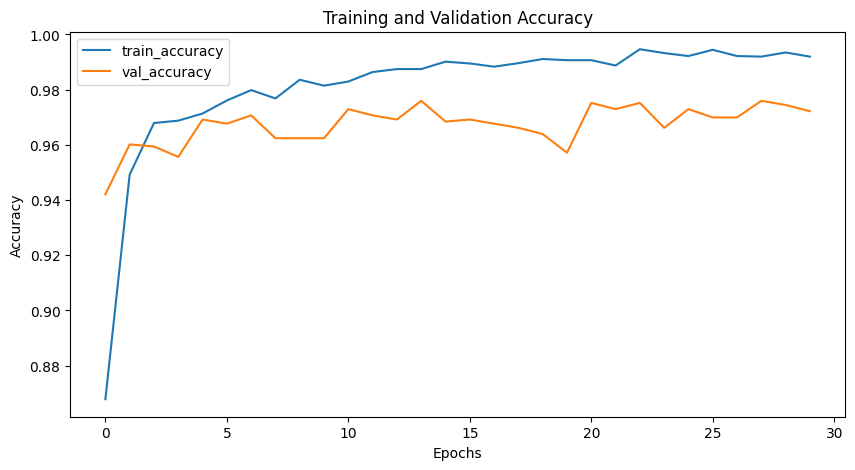

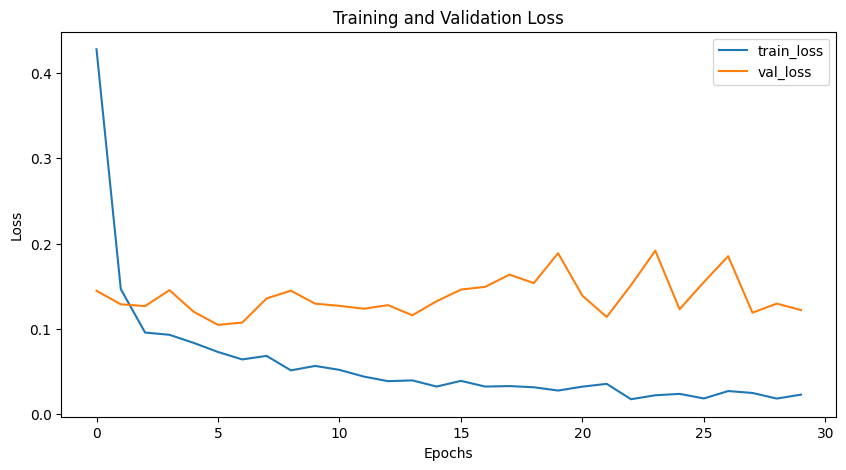

In [24]:
# Ploting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Ploting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 743ms/step - accuracy: 0.9781 - loss: 0.1093
Test accuracy: 96.71%


W0000 00:00:1722624419.870423     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
# Predicting on test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

 1/84 ━━━━━━━━━━━━━━━━━━━━ 4:02 3s/step

W0000 00:00:1722624423.111998     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 544ms/step


W0000 00:00:1722624468.234308     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


                             precision    recall  f1-score   support

         Corn___Common_Rust       1.00      1.00      1.00       239
      Corn___Gray_Leaf_Spot       0.96      0.94      0.95       103
             Corn___Healthy       1.00      1.00      1.00       233
Corn___Northern_Leaf_Blight       0.97      0.98      0.98       198
      Potato___Early_Blight       1.00      1.00      1.00       201
           Potato___Healthy       1.00      1.00      1.00        31
       Potato___Late_Blight       1.00      1.00      1.00       201
          Rice___Brown_Spot       0.83      0.87      0.85       123
             Rice___Healthy       0.89      0.94      0.92       298
          Rice___Leaf_Blast       0.92      0.81      0.86       196
          Rice___Neck_Blast       1.00      1.00      1.00       201
 Sugarcane_Bacterial Blight       1.00      0.95      0.98        21
          Sugarcane_Healthy       0.95      1.00      0.98        21
          Sugarcane_Red Rot      

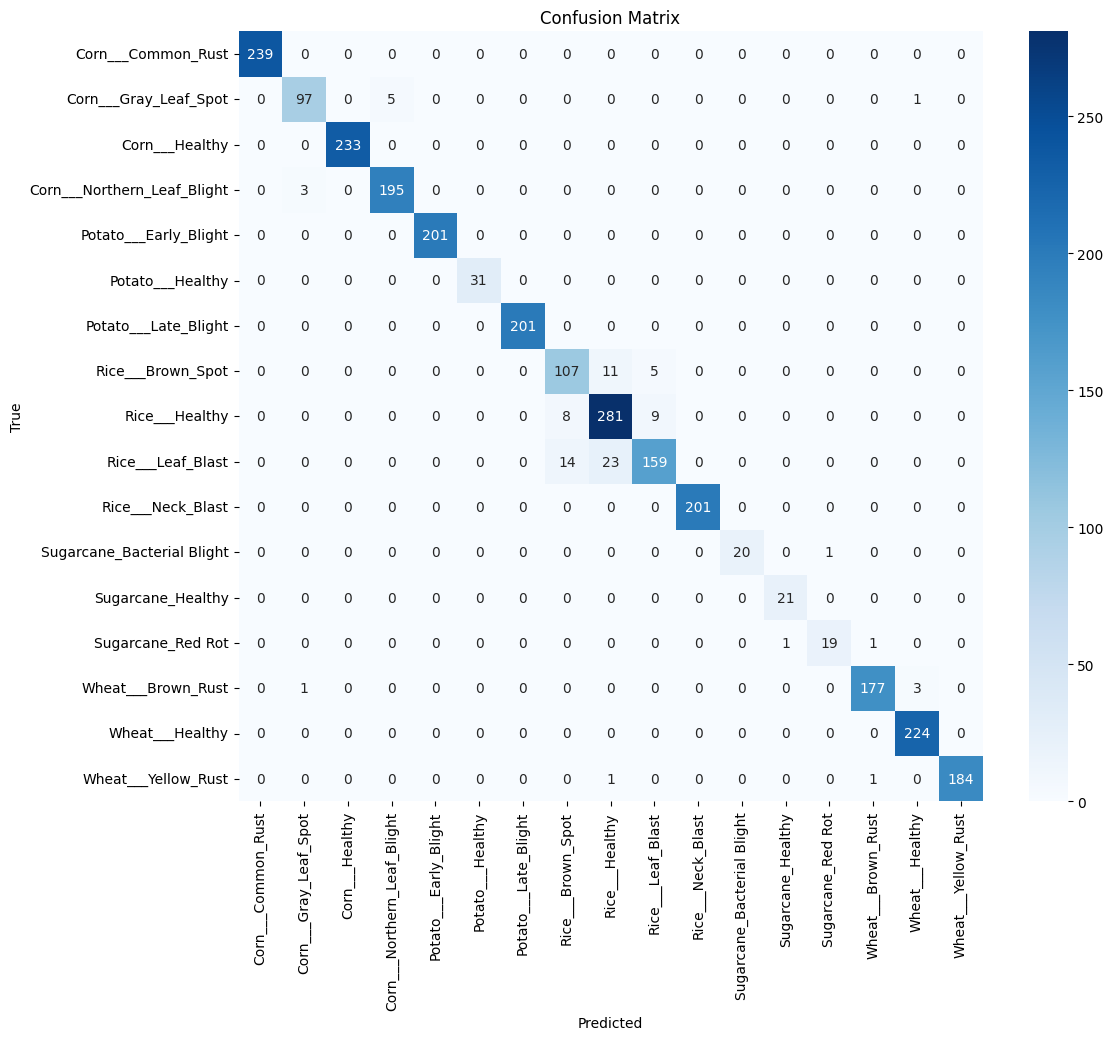

In [27]:
# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
#Saving the model
model.save('/kaggle/working/model.h5')